# Cookie factory

You are the manager of a company which produces cookies and you want to introduce a new product. Your R\&D department has proposed and developed the following two alternatives:

1. Unicorn cookies (UC)
2. Vanilla-chip cookies (VC).

As part of your market research, you are interested in predicting whether certain customers are likely to buy one of the new products. For that, you have already collected data from a large number of test persons.
In particular, you asked them to fill out a query with the following questions:

1. *What do you think is the most fascinating: Rainbows, Black holes or Cats?* (variable $preferences$)
2. *How much money do you spend on cookies per month?* (variable $money$)
3. *Which of our cookies would you buy?* (variable $product$)  
   *Note*: The variable $product$ can also take on the value "No product" (NP).

You can find the data in *cookie-factory.csv*.

## Imports and data

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import scipy.stats as dists

In [7]:
data = pd.read_csv("cookie-factory.csv")
data.head()

,product,age,preferences,money
0,Unicorn,16,Rainbows,12.65
1,No product,58,Cats,25.91
2,Vanilla,38,Cats,25.39
3,Unicorn,28,Rainbows,18.05
4,Unicorn,45,Cats,3.27


## Data visualization

Nothing to do here...

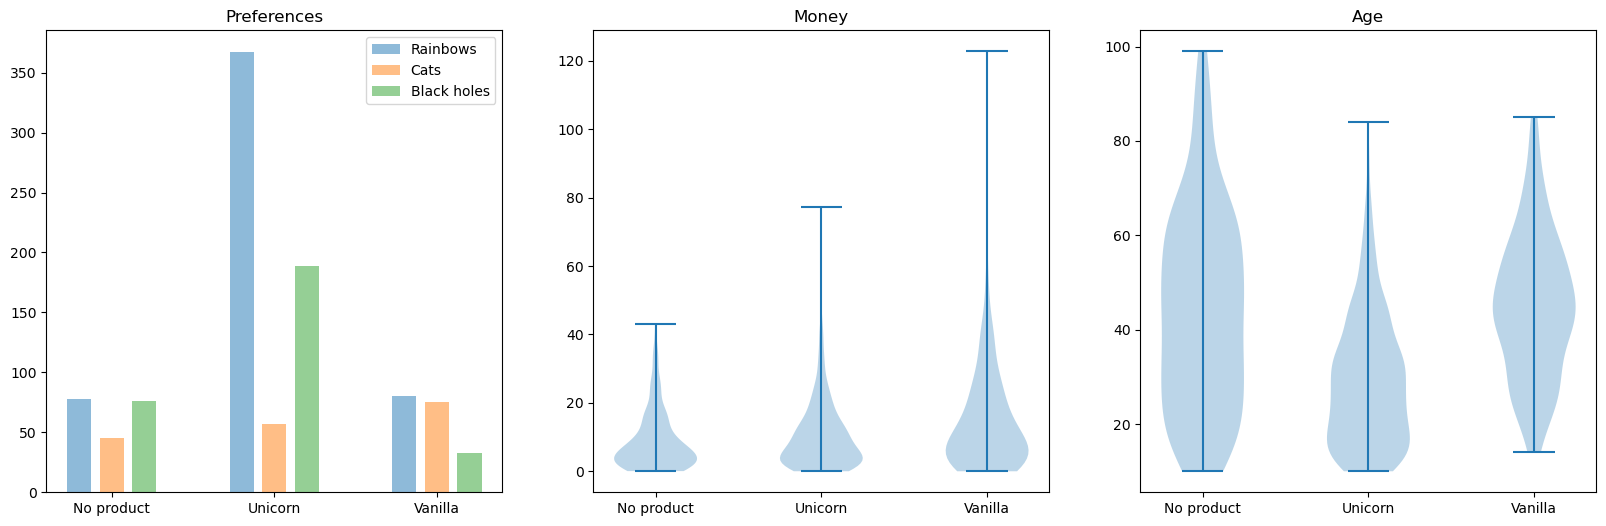

In [3]:
pd.set_option("future.no_silent_downcasting", True)

fig, axs = plt.subplots(1, 3, figsize=(20, 6))

for i, preference in enumerate(data["preferences"].unique()):
    x = data.loc[data["preferences"] == preference, "product"].replace(
        ["No product", "Unicorn", "Vanilla"], [-1, 0, 1]
    )
    labels, counts = np.unique(x, return_counts=True)
    axs[0].bar(
            labels + 0.2 * (i - 1), counts, alpha=0.5, label=preference, width=0.15, align="center"
        )
axs[0].set_xticks([-1, 0, 1])
axs[0].set_xticklabels(["No product", "Unicorn", "Vanilla"])
axs[0].legend()
axs[0].set_title("Preferences")

axs[1].violinplot([data.loc[data["product"] == "No product", "money"],

                   data.loc[data["product"] == "Unicorn", "money"],
                   data.loc[data["product"] == "Vanilla", "money"]])
axs[1].set_xticks([1, 2, 3])
axs[1].set_xticklabels(["No product", "Unicorn", "Vanilla"])
axs[1].set_title("Money");

axs[2].violinplot([data.loc[data["product"] == "No product", "age"],

                   data.loc[data["product"] == "Unicorn", "age"],
                   data.loc[data["product"] == "Vanilla", "age"]])
axs[2].set_xticks([1, 2, 3])
axs[2].set_xticklabels(["No product", "Unicorn", "Vanilla"])
axs[2].set_title("Age");

## a)

For each of the questions 1-3, decide
- whether the answers are continuous or discrete outcomes,
- which range the outcomes could have
- to which scale of measurement (nominal, ordinal, interval, ratio) the outcomes belong to.

- 1. What do you think is the most fascinating: Rainbows, Black holes or Cats? (variable preferences)?
  2. How much money do you spend on cookies per month? (variable money)
  3. Which of our cookies would you buy? (variable product) Note: The variable productcan also take on the value "No product" (NP).
# Answers:
- preferences -> discrete, money -> continuous, product -> discrete
- preferences range (0, 350), money range (0, 120), Age range (0, 100)
- preferences -> categorical (nominal), money -> ordinal, product -> interval

## b)

To infer which products new customers are likely to buy, you set up a probabilistic model.
You assume that the answers to questions 1 - 3 are conditionally independent (Naive Bayes) given $product$ and model the dependencies as follows:
$$
f(preferences, money, product) = \\
		\mathbb{P}(preferences ~\vert~ product) \cdot f_{money}(money ~\vert~ product) \cdot \mathbb{P}(product)
$$

Estimate the parameters of your categorical prior by using maximum likelihood:
$$
\mathbb{P}(product = UC) = p_{UC} \qquad \mathbb{P}(product = VC) = p_{VC} \qquad \mathbb{P}(product = NP) = p_{NP}
$$

*Hint*: The maximum likelihood estimate of the parameters for categorically distributed variables is simply the fraction of samples from a category.

In [9]:
product_counts = data["product"].value_counts(normalize=True)
p_UC = product_counts.get("Unicorn", 0)
p_NP = product_counts.get("No product", 0)
p_VC = product_counts.get("Vanilla", 0)
print(f"Prior Probability of product=UC: {p_UC}")
print(f"Prior Probability of product=VC: {p_VC}")
print(f"Prior Probability of product=NP: {p_NP}")

Prior Probability of product=UC: 0.613
Prior Probability of product=VC: 0.188
Prior Probability of product=NP: 0.199


## c)

Based on your observations in a), you decide to model the likelihoods as follows:

1. $preferences$ follows a Categorical distribution where the parameters depend on the product the customers would buy.

2. $money$ follows an exponential distribution where the parameter $\lambda_{product}$ depends on the product the customers would buy ($\eta_{product} = \eta_{UC}$, $\eta_{product} = \eta_{VC}$ or $\eta_{product} = \eta_{NP}$):
    $$
        f_{money}(m \vert product) = \begin{cases}
            \eta_{product} \cdot e^{-\eta_{product} \cdot m} & m \geq 0 \\
            0 & \text{else}
        \end{cases}
    $$


Intuitively, your model describes the profile ($preferences$, $money$) of a customer if you already know which product they would buy ($product$).
        
Using the data, derive maximum likelihood estimates for all parameters.

*Hint*: The maximum likelihood estimate of the parameters for exponentially distributed variables is the inverse of their sample mean: $\bar{x}^{-1}$.  
*Hint*: The maximum likelihood estimate of the parameters for categorically distributed variables is simply the fraction of samples from a category.

# Answer (1.):
- The variable preferences is modeled as a categorical distribution, where the probability of each category (e.g., Unicorn, Vanilla, No product) depends on the product the customer would buy. The MLE for each category within a categorical variable is the **relative frequency** of each category, given the product type.

In [11]:
preference_counts = data.groupby(["product", "preferences"]).size().unstack(fill_value=0)
preference_probs = preference_counts.divide(preference_counts.sum(axis=1), axis=0)
print("Preference probability by product:")
print(preference_probs)

Preference probability by product:
preferences  Black holes      Cats  Rainbows
product                                     
No product      0.381910  0.226131  0.391960
Unicorn         0.308320  0.092985  0.598695
Vanilla         0.175532  0.398936  0.425532


# Answer (2.):
- exponential distribution, -> but money depends on product

In [13]:
money_counts = data.groupby("product")["money"].mean()
eta_UC = 1 / money_counts.get("Unicorn", 1) # Ensure no zero devision if `Unicorn` is missing
eta_VC = 1 / money_counts.get("Vanilla", 1)
eta_NP = 1 / money_counts.get("No product", 1)

print(f"η_UC (rate for Unicorn): {eta_UC}")
print(f"η_VC (rate for Vanilla): {eta_VC}")
print(f"η_NP (rate for No product): {eta_NP}")

η_UC (rate for Unicorn): 0.09134434134471388
η_VC (rate for Vanilla): 0.06643978187960971
η_NP (rate for No product): 0.1121619641307166


## d) + e)

You now have access to a joint density over your data:
$$
f(preferences, money, product) = \\
    \mathbb{P}(preferences ~\vert~ product) \cdot f_{money}(money ~\vert~ product) \cdot \mathbb{P}(product)
$$
	
With the fitted model, predict the (posterior) probability
$$
	\mathbb{P}(product ~\vert~ preferences, money)
$$
that the customers below buy a unicorn cookie, a vanilla-chip cookie or no cookie at all:

| Customer  | $preferences$  | $money$   |
| --------- | ------------- | ---------:|
| Anna      | Cats          | 53.10 €   |
| Ben       | Rainbows      | 2.30 €    |
| Caroline  | Black holes   | 10.25 €   |
| ???       | Rainbows      | ??        |

Helpful distributions:
- [Exponential](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.expon.html#scipy.stats.expon)

In [14]:
# Preference probabilities by product (computed previously)
# Replace with actual calculated probabilities for each preference
preference_probs = {
    'Unicorn': {'Cats': 0.092985, 'Rainbows': 0.598695, 'Black holes': 0.308320},
    'Vanilla': {'Cats': 0.398936, 'Rainbows': 0.425532, 'Black holes': 0.175532},
    'No product': {'Cats': 0.226131, 'Rainbows': 0.391960, 'Black holes': 0.381910}
}

# Function to compute likelihood for money (exponential distribution)
def money_likelihood(money, eta):
    return eta * np.exp(-eta * money) if money >= 0 else 0

# Function to compute posterior probability for each product
def compute_posterior(preference, money):
    products = ['Unicorn', 'Vanilla', 'No product']
    priors = [p_UC, p_VC, p_NP]
    etas = [eta_UC, eta_VC, eta_NP]
    
    # Calculate the unnormalized posterior for each product
    posteriors = []
    for i, product in enumerate(products):
        pref_prob = preference_probs[product].get(preference, 0)
        money_prob = money_likelihood(money, etas[i])
        posterior = pref_prob * money_prob * priors[i]
        posteriors.append(posterior)
    
    # Normalize to get the final posterior probabilities
    total = sum(posteriors)
    posteriors = [p / total for p in posteriors] if total > 0 else [0, 0, 0]
    
    return dict(zip(products, posteriors))

In [15]:
customers = [
    {"name": "Anna", "preferences": "Cats", "money": 53.10},
    {"name": "Ben", "preferences": "Rainbows", "money": 2.30},
    {"name": "Caroline", "preferences": "Black holes", "money": 10.25},
    {"name": "???", "preferences": "Rainbows", "money": None}  # Money unknown for ??? 
]

# Compute posterior probabilities for each customer
for customer in customers:
    print(f"\nCustomer: {customer['name']}")
    if customer['money'] is not None:
        posterior = compute_posterior(customer['preferences'], customer['money'])
        print(f"Posterior probabilities: {posterior}")
    else:
        print("Insufficient data to compute posterior (money missing)")


Customer: Anna
Posterior probabilities: {'Unicorn': 0.20357041076284055, 'Vanilla': 0.7310951074272412, 'No product': 0.06533448180991831}

Customer: Ben
Posterior probabilities: {'Unicorn': 0.7058812616864495, 'Vanilla': 0.11851648708687512, 'No product': 0.17560225122667542}

Customer: Caroline
Posterior probabilities: {'Unicorn': 0.6398712019624466, 'Vanilla': 0.1048948577832077, 'No product': 0.25523394025434565}

Customer: ???
Insufficient data to compute posterior (money missing)


- For the last customer (???), since we don’t have the money value, we can’t compute a full posterior probability. However, if needed, we could base our prediction solely on preferences and the prior P(product) by removing money from the computation.

## f) [Bonus]

You may have noticed that the data also contains information about age. What would you need to do to include this information as well?

- (1) First, we need to model how age varies depending on the product. Here are some options:
Categorical/Discrete: If age is divided into bins (e.g., 18–25, 26–35), it can be treated as a categorical variable similar to preferences. We would estimate the probability of each age bin given product.
Continuous (Normal Distribution): If age is treated as a continuous variable, we could assume it follows a normal distribution, with a mean and variance that depend on the product: where $\mu_{prodcut}$ and $\sigma_{product}$are the mean and standard deviation of age for each product type.
- (2) **Estimate Parameters for Age:** If Categorical: Estimate the probability of each age bin within each product category, similar to how we computed the probabilities for preferences. If Continuous (Normal): Estimate using the sample mean and standard deviation of age for each product type.
- (3) Update the Joint Probability Density 